# Part 1: 무역 수출 서프라이즈 정의하기
- 과제 목표
- 과거 데이터를 기반으로 수출 실적이 예상 대비 얼마나 놀라운지를 측정하는 surprise 지표를 만듭니다. 이 지표는 이후 2, 3, 4번 과제의 핵심 입력값으로 사용됩니다.

In [15]:
import os
base_path = r'C:\Users\PC2502\OneDrive\HSU\Singapore\presto-project'
data_path = os.path.join(base_path, 'data') 

In [16]:
# 데이터 로드 
import pandas as pd
import numpy as np

# 1. 수출 데이터 로드
export_value_data_path = os.path.join(data_path, 'export_value.csv')
export = pd.read_csv(export_value_data_path)
export['date'] = pd.to_datetime(export['date'])

print("=" * 80)
print("데이터 구조 확인")
print("=" * 80)
print(f"Shape: {export.shape}")
print(f"Columns: {export.columns.tolist()}")
print(f"Date range: {export['date'].min()} ~ {export['date'].max()}")
print(f"Unique symbols: {export['symbol'].nunique()}")
print(f"\n첫 5행:")
print(export.head())
print(f"\n기초 통계:")
print(export['export_value'].describe())

데이터 구조 확인
Shape: (22659, 3)
Columns: ['date', 'symbol', 'export_value']
Date range: 2020-01-31 00:00:00 ~ 2025-10-31 00:00:00
Unique symbols: 349

첫 5행:
        date  symbol  export_value
0 2020-01-31  ZPWVVS       2865954
1 2020-01-31  YRTSYY      10836746
2 2020-01-31  OOVKZQ     861314197
3 2020-01-31  DKEETE      16163843
4 2020-01-31  AUBZAL       2657843

기초 통계:
count    2.265900e+04
mean     5.734279e+07
std      2.867482e+08
min      3.000000e+00
25%      2.172296e+06
50%      6.060556e+06
75%      1.572149e+07
max      5.725632e+09
Name: export_value, dtype: float64


In [17]:
def calculate_growth_rates(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    
    df = df.sort_values(['symbol', 'date'])
    
    # 성장률 계산 (NaN 그대로 유지)
    df['export_value_lag12'] = df.groupby('symbol')['export_value'].shift(12)
    df['yoy'] = (df['export_value'] - df['export_value_lag12']) / df['export_value_lag12']
    
    df['quarter_avg'] = df.groupby(['symbol', 'year', 'quarter'])['export_value'].transform('mean')
    df['quarter_avg_lag1'] = df.groupby('symbol')['quarter_avg'].shift(1)
    df['qoq'] = (df['quarter_avg'] - df['quarter_avg_lag1']) / df['quarter_avg_lag1']
    
    df['export_value_lag1'] = df.groupby('symbol')['export_value'].shift(1)
    df['mom'] = (df['export_value'] - df['export_value_lag1']) / df['export_value_lag1']
    
    # NaN 정보 출력
    print("\n=== NaN 개수 ===")
    print(f"YoY: {df['yoy'].isna().sum()} / {len(df)}")
    print(f"QoQ: {df['qoq'].isna().sum()} / {len(df)}")
    print(f"MoM: {df['mom'].isna().sum()} / {len(df)}")
    
    return df


In [18]:
# 사용
export = calculate_growth_rates(export)

export_with_yoy = export[export['yoy'].notna()]


=== NaN 개수 ===
YoY: 4157 / 22659
QoQ: 349 / 22659
MoM: 349 / 22659


In [19]:
print("\n방법 2 - groupby 후 선택:")
result2 = export.groupby('symbol')['yoy'].mean()['AEGQRD']
print(result2)



방법 2 - groupby 후 선택:
1.3902955355662412


## Step 2: Surprise 개념 이해하기

**Surprise란?**
- "실제 발표된 값이 시장의 예상치와 얼마나 다른지"를 의미
- 단순히 수출액이 높다 ≠ Surprise
- **예상과 달랐을 때** = 진짜 Surprise!

**핵심 개념:**
- Positive Surprise: 예상보다 훨씬 좋은 실적
- Negative Surprise: 예상보다 나쁜 실적
- 주식 시장은 "평균적인 성장"을 이미 주가에 반영
- **예상과의 차이**가 새로운 정보 → 주가 변동

**목표:**
"평소 패턴 대비 얼마나 이례적인가"를 수치화

## Step 3: 전체 기간 Z-Score 계산하기

**Z-Score 공식:** `z = (x - μ) / σ`
- x: 관측값 (예: 이번 달 YoY)
- μ: 평균 (과거 YoY의 평균)
- σ: 표준편차 (과거 YoY의 표준편차)

**해석:**
- Z-Score = 0: 정확히 평균
- Z-Score = 1: 평균보다 1 표준편차 위 (상위 16%)
- Z-Score = 2: 상위 2.5% (매우 이례적)
- Z-Score = 3: 상위 0.1% (극히 드문 사건)

**왜 사용하나?**
서로 다른 기업을 공정하게 비교하기 위해 (각 기업의 "평소 패턴" 고려)


In [20]:
# Step 3: 전체 기간 Z-Score 계산
import matplotlib.pyplot as plt

# 각 기업별로 전체 기간 평균과 표준편차를 계산하여 Z-Score 구하기
def calculate_zscore(df, column):
    """기업별 전체 기간 Z-Score 계산"""
    # 기업별 평균과 표준편차
    group_mean = df.groupby('symbol')[column].transform('mean')
    group_std = df.groupby('symbol')[column].transform('std')
    
    # Z-Score 계산
    zscore = (df[column] - group_mean) / group_std
    
    return zscore

# YoY, QoQ, MoM에 대해 Z-Score 계산
export['zscore_yoy'] = calculate_zscore(export, 'yoy')
export['zscore_qoq'] = calculate_zscore(export, 'qoq')
export['zscore_mom'] = calculate_zscore(export, 'mom')

print("=" * 80)
print("전체 기간 Z-Score 기초 통계")
print("=" * 80)
print("\nYoY Z-Score:")
print(export['zscore_yoy'].describe())
print(f"\n|Z-Score| > 2인 비율: {(export['zscore_yoy'].abs() > 2).sum() / export['zscore_yoy'].notna().sum() * 100:.2f}%")
print(f"이론적 비율: ~5%")

print("\n" + "=" * 80)
print("극단적 Surprise 사례 (YoY 기준)")
print("=" * 80)
print("\nTop 10 Positive Surprises:")
top_surprises = export.nlargest(10, 'zscore_yoy')[['date', 'symbol', 'yoy', 'zscore_yoy']]
print(top_surprises.to_string(index=False))

print("\nTop 10 Negative Surprises:")
bottom_surprises = export.nsmallest(10, 'zscore_yoy')[['date', 'symbol', 'yoy', 'zscore_yoy']]
print(bottom_surprises.to_string(index=False))


전체 기간 Z-Score 기초 통계

YoY Z-Score:
count    1.850200e+04
mean    -2.400223e-18
std      9.906869e-01
min     -2.426567e+00
25%     -5.646300e-01
50%     -2.116323e-01
75%      3.075760e-01
max      7.484466e+00
Name: zscore_yoy, dtype: float64

|Z-Score| > 2인 비율: 4.42%
이론적 비율: ~5%

극단적 Surprise 사례 (YoY 기준)

Top 10 Positive Surprises:
      date symbol           yoy  zscore_yoy
2022-05-31 OUKEEB 768983.929487    7.484466
2023-10-31 JYFXNM  27803.851216    7.473076
2021-02-28 IMYNMI  40245.852941    7.416676
2021-04-30 DUYYKV     26.401451    7.407396
2021-02-28 XNXMBG    144.274382    7.390765
2025-10-31 IOPEDG     40.594335    7.303799
2024-07-31 GQQMUO    707.513942    7.267920
2023-06-30 YCDYBQ   1212.949601    7.241604
2021-05-31 UZFBRJ     10.910033    7.147711
2023-01-31 OCDYNK    144.037085    7.132972

Top 10 Negative Surprises:
      date symbol       yoy  zscore_yoy
2023-01-31 DHMCLM -0.900602   -2.426567
2021-05-31 BRCOZW -0.246160   -2.328120
2023-02-28 DHMCLM -0.849452   -2.

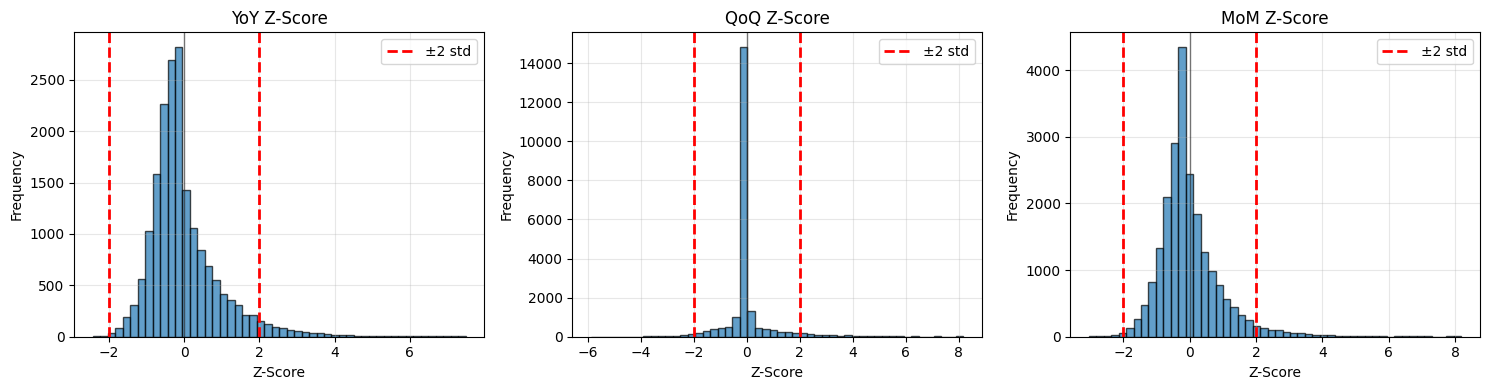

Z-Score 분포 그래프 저장: zscore_distribution.png


In [21]:
# Z-Score 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (col, title) in enumerate([('zscore_yoy', 'YoY Z-Score'), 
                                       ('zscore_qoq', 'QoQ Z-Score'), 
                                       ('zscore_mom', 'MoM Z-Score')]):
    ax = axes[idx]
    data = export[col].dropna()
    
    # 히스토그램
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    
    # ±2 표준편차 선
    ax.axvline(-2, color='red', linestyle='--', linewidth=2, label='±2 std')
    ax.axvline(2, color='red', linestyle='--', linewidth=2)
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Z-Score')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'zscore_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Z-Score 분포 그래프 저장: zscore_distribution.png")


## Step 4: Rolling Window - Forward-Looking Bias 해결

**문제점: 전체 기간 Z-Score의 치명적 결함**
- 미래 정보를 사용함 (Look-Ahead Bias)
- 2022년 6월의 Z-Score 계산 시 2024년 데이터까지 사용 → 현실 불가능
- 백테스트 결과가 실제와 괴리됨

**해결책: Rolling Window**
- 특정 시점의 Z-Score 계산 시, **그 시점까지의 과거 데이터만** 사용
- "움직이는 창문"처럼 작동

**Trade-off:**
- 짧은 window (12개월): 빠른 반응, 불안정한 추정
- 긴 window (36개월): 안정적, 느린 반응, 많은 데이터 손실

**권장: 24개월 Rolling Window**
1. 계절성을 2회 포함 → 안정적 패턴 추정
2. 최근 2년 트렌드 반영
3. YoY는 12개월 차이이므로, 24개월이면 최소 2개의 YoY 비교 가능


## Step 5: Rolling Z-Score 계산 (진짜 Surprise 지표!)

**Rolling의 의미:**
- 2023년 6월 Z-Score = 2021년 7월 ~ 2023년 6월 (24개월) 데이터만 사용
- 2023년 7월 Z-Score = 2021년 8월 ~ 2023년 7월 (24개월) 데이터만 사용
- 각 시점에서 "그때 사용 가능했던 정보"만 활용


In [22]:
# Step 5: Rolling Z-Score 계산 (최종 Surprise 지표)

def calculate_rolling_zscore(df, column, window=24, min_periods=12):
    """
    Rolling Z-Score 계산 (Forward-Looking Bias 방지)
    
    Parameters:
    - df: DataFrame
    - column: Z-Score를 계산할 컬럼
    - window: Rolling window 크기 (개월 수)
    - min_periods: 최소 필요 데이터 포인트 수
    
    Returns:
    - Rolling Z-Score Series
    """
    # 결과를 저장할 Series 생성
    rolling_zscore = pd.Series(index=df.index, dtype=float)
    
    # 기업별로 처리
    for symbol in df['symbol'].unique():
        # 해당 기업 데이터만 추출 (날짜순 정렬)
        mask = df['symbol'] == symbol
        symbol_data = df.loc[mask].sort_values('date')
        
        # 해당 컬럼의 데이터
        values = symbol_data[column]
        
        # Rolling mean과 std 계산
        rolling_mean = values.rolling(window=window, min_periods=min_periods).mean()
        rolling_std = values.rolling(window=window, min_periods=min_periods).std()
        
        # Z-Score 계산: (현재값 - rolling평균) / rolling표준편차
        zscore = (values - rolling_mean) / rolling_std
        
        # 결과 저장
        rolling_zscore.loc[symbol_data.index] = zscore
    
    return rolling_zscore

print("=" * 80)
print("Rolling Z-Score 계산 시작 (24개월 window)")
print("=" * 80)

# YoY, QoQ, MoM에 대해 Rolling Z-Score 계산
window_size = 24

export['rolling_zscore_yoy'] = calculate_rolling_zscore(export, 'yoy', window=window_size)
print("YoY Rolling Z-Score 계산 완료")

export['rolling_zscore_qoq'] = calculate_rolling_zscore(export, 'qoq', window=window_size)
print("QoQ Rolling Z-Score 계산 완료")

export['rolling_zscore_mom'] = calculate_rolling_zscore(export, 'mom', window=window_size)
print("MoM Rolling Z-Score 계산 완료")

print("\n" + "=" * 80)
print("Rolling Z-Score 기초 통계")
print("=" * 80)
print("\nYoY Rolling Z-Score:")
print(export['rolling_zscore_yoy'].describe())
print(f"결측치: {export['rolling_zscore_yoy'].isna().sum()} / {len(export)}")
print(f"|Z-Score| > 2인 비율: {(export['rolling_zscore_yoy'].abs() > 2).sum() / export['rolling_zscore_yoy'].notna().sum() * 100:.2f}%")


Rolling Z-Score 계산 시작 (24개월 window)
YoY Rolling Z-Score 계산 완료
QoQ Rolling Z-Score 계산 완료
MoM Rolling Z-Score 계산 완료

Rolling Z-Score 기초 통계

YoY Rolling Z-Score:
count    14718.000000
mean        -0.086008
std          1.044627
min         -3.217764
25%         -0.752896
50%         -0.308683
75%          0.358596
max          4.694848
Name: rolling_zscore_yoy, dtype: float64
결측치: 7941 / 22659
|Z-Score| > 2인 비율: 5.65%


C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\3171326254.py:31: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\3171326254.py:31: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\3171326254.py:31: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\3171326254.py:32: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(base_path, 'rolling_zscore_timeseries.png'), dpi=150, bbox_inches='tight')
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\3171326254.py:32: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(base_path, 'rolling_zscore_timeseries.png

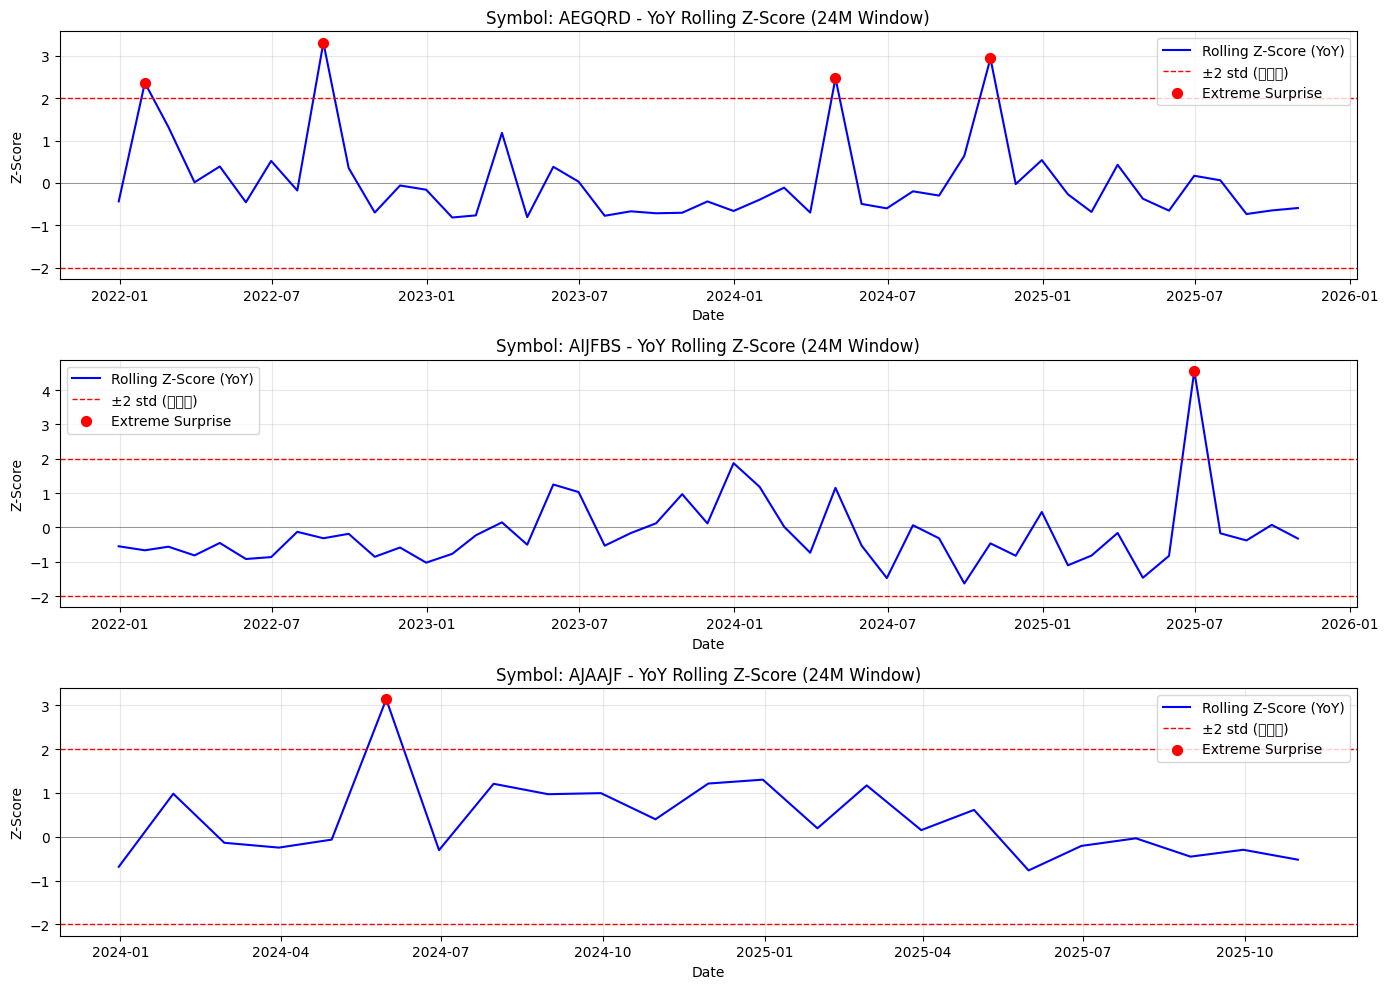

Rolling Z-Score 시계열 그래프 저장: rolling_zscore_timeseries.png


In [23]:
# Rolling Z-Score 시계열 시각화 (샘플 기업)
# 무작위로 3개 기업 선택
sample_symbols = export['symbol'].unique()[:3]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, symbol in enumerate(sample_symbols):
    ax = axes[idx]
    symbol_data = export[export['symbol'] == symbol].sort_values('date')
    
    # Rolling Z-Score 플롯
    ax.plot(symbol_data['date'], symbol_data['rolling_zscore_yoy'], 
            linewidth=1.5, label='Rolling Z-Score (YoY)', color='blue')
    
    # ±2 표준편차 선
    ax.axhline(2, color='red', linestyle='--', linewidth=1, label='±2 std (이상치)')
    ax.axhline(-2, color='red', linestyle='--', linewidth=1)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # 이상치 강조
    outliers = symbol_data[symbol_data['rolling_zscore_yoy'].abs() > 2]
    ax.scatter(outliers['date'], outliers['rolling_zscore_yoy'], 
               color='red', s=50, zorder=5, label='Extreme Surprise')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Z-Score')
    ax.set_title(f'Symbol: {symbol} - YoY Rolling Z-Score (24M Window)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'rolling_zscore_timeseries.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Rolling Z-Score 시계열 그래프 저장: rolling_zscore_timeseries.png")


C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\1215096545.py:28: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\1215096545.py:28: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\1215096545.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\1215096545.py:28: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\1215096545.py:28: UserWarning: Glyph 51080 (\N{HANGUL SYLLABLE ISS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC2502\AppData\Local\Temp\ipykernel_22312\1215096545.py:28: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missin

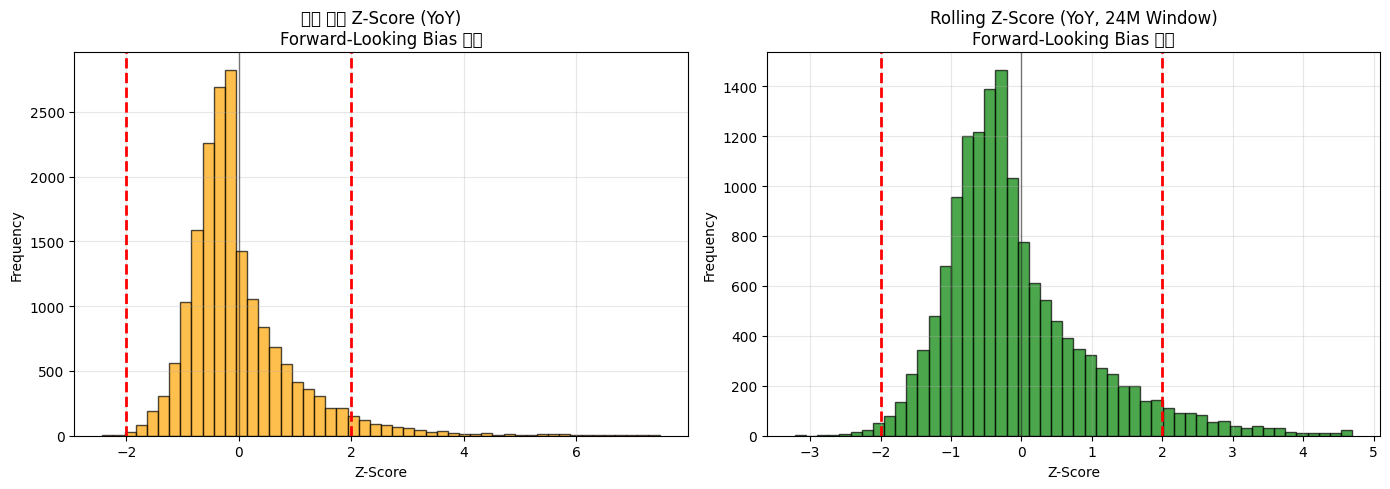

Z-Score 비교 그래프 저장: zscore_comparison.png


In [24]:
# 전체 기간 Z-Score vs Rolling Z-Score 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 전체 기간 Z-Score
ax = axes[0]
data = export['zscore_yoy'].dropna()
ax.hist(data, bins=50, alpha=0.7, edgecolor='black', color='orange')
ax.axvline(-2, color='red', linestyle='--', linewidth=2)
ax.axvline(2, color='red', linestyle='--', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Z-Score')
ax.set_ylabel('Frequency')
ax.set_title('전체 기간 Z-Score (YoY)\nForward-Looking Bias 있음')
ax.grid(True, alpha=0.3)

# Rolling Z-Score
ax = axes[1]
data = export['rolling_zscore_yoy'].dropna()
ax.hist(data, bins=50, alpha=0.7, edgecolor='black', color='green')
ax.axvline(-2, color='red', linestyle='--', linewidth=2)
ax.axvline(2, color='red', linestyle='--', linewidth=2)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Z-Score')
ax.set_ylabel('Frequency')
ax.set_title('Rolling Z-Score (YoY, 24M Window)\nForward-Looking Bias 제거')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'zscore_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("Z-Score 비교 그래프 저장: zscore_comparison.png")


In [25]:
# Forward-Looking Bias 검증
# 특정 날짜를 선택하여 수동 계산과 비교
test_symbol = export['symbol'].iloc[500]
test_date_idx = 35  # 충분한 과거 데이터가 있는 시점

symbol_data = export[export['symbol'] == test_symbol].sort_values('date').reset_index(drop=True)

if len(symbol_data) > test_date_idx + window_size:
    test_date = symbol_data.loc[test_date_idx, 'date']
    test_value = symbol_data.loc[test_date_idx, 'yoy']
    calculated_zscore = symbol_data.loc[test_date_idx, 'rolling_zscore_yoy']
    
    # 수동 계산: 과거 24개월 데이터만 사용
    past_24_months = symbol_data.loc[test_date_idx-window_size+1:test_date_idx, 'yoy']
    manual_mean = past_24_months.mean()
    manual_std = past_24_months.std()
    manual_zscore = (test_value - manual_mean) / manual_std
    
    print("=" * 80)
    print("Forward-Looking Bias 검증")
    print("=" * 80)
    print(f"테스트 기업: {test_symbol}")
    print(f"테스트 날짜: {test_date}")
    print(f"YoY 값: {test_value:.4f}")
    print(f"\n과거 24개월 통계:")
    print(f"  평균: {manual_mean:.4f}")
    print(f"  표준편차: {manual_std:.4f}")
    print(f"\n프로그램 계산 Z-Score: {calculated_zscore:.4f}")
    print(f"수동 계산 Z-Score: {manual_zscore:.4f}")
    print(f"차이: {abs(calculated_zscore - manual_zscore):.6f}")
    
    if abs(calculated_zscore - manual_zscore) < 0.001:
        print("\n검증 성공! Forward-Looking Bias가 없습니다.")
    else:
        print("\n경고: 차이가 있습니다. 코드를 다시 확인하세요.")
else:
    print("검증을 위한 충분한 데이터가 없습니다.")


Forward-Looking Bias 검증
테스트 기업: ASANPU
테스트 날짜: 2022-12-31 00:00:00
YoY 값: 0.0809

과거 24개월 통계:
  평균: 0.3308
  표준편차: 0.2940

프로그램 계산 Z-Score: -0.8498
수동 계산 Z-Score: -0.8498
차이: 0.000000

검증 성공! Forward-Looking Bias가 없습니다.


## Step 7: 최종 데이터 저장

**중요:** 이 파일이 Part 2, 3, 4의 입력 데이터가 됩니다!


In [26]:
# Step 7: 최종 데이터 저장

# 저장할 컬럼 선택
output_columns = [
    'date',
    'symbol',
    'export_value',
    'yoy', 'qoq', 'mom',  # 성장률
    'rolling_zscore_yoy', 'rolling_zscore_qoq', 'rolling_zscore_mom'  # Surprise 지표
]

# 데이터 저장
output_file = os.path.join(data_path, 'export_with_surprise.csv')
export[output_columns].to_csv(output_file, index=False)

print("=" * 80)
print("최종 데이터 저장 완료!")
print("=" * 80)
print(f"파일명: {output_file}")
print(f"전체 행 수: {len(export):,}")
print(f"컬럼: {output_columns}")
print("\n데이터 미리보기:")
print(export[output_columns].head(10))

# 데이터 품질 체크
print("\n" + "=" * 80)
print("데이터 품질 체크")
print("=" * 80)
for col in output_columns:
    non_null = export[col].notna().sum()
    null_pct = (1 - non_null / len(export)) * 100
    print(f"{col:25s}: {non_null:6,} / {len(export):,} ({null_pct:5.2f}% 결측)")

print("\n" + "=" * 80)
print("Rolling Z-Score 통계 요약 (Surprise 지표)")
print("=" * 80)
for col in ['rolling_zscore_yoy', 'rolling_zscore_qoq', 'rolling_zscore_mom']:
    data = export[col].dropna()
    extreme = (data.abs() > 2).sum()
    extreme_pct = extreme / len(data) * 100
    print(f"\n{col}:")
    print(f"  평균: {data.mean():.4f}")
    print(f"  표준편차: {data.std():.4f}")
    print(f"  |Z-Score| > 2: {extreme:,} ({extreme_pct:.2f}%)")
    print(f"  최댓값: {data.max():.4f}")
    print(f"  최솟값: {data.min():.4f}")


최종 데이터 저장 완료!
파일명: C:\Users\PC2502\OneDrive\HSU\Singapore\presto-project\data\export_with_surprise.csv
전체 행 수: 22,659
컬럼: ['date', 'symbol', 'export_value', 'yoy', 'qoq', 'mom', 'rolling_zscore_yoy', 'rolling_zscore_qoq', 'rolling_zscore_mom']

데이터 미리보기:
           date  symbol  export_value  yoy       qoq       mom  \
216  2020-01-31  AEGQRD        319383  NaN       NaN       NaN   
502  2020-02-29  AEGQRD        139327  NaN  0.000000 -0.563762   
791  2020-03-31  AEGQRD        216989  NaN  0.000000  0.557408   
1080 2020-04-30  AEGQRD         37790  NaN -0.614268 -0.825844   
1367 2020-05-31  AEGQRD        147052  NaN  0.000000  2.891294   
1656 2020-06-30  AEGQRD         75797  NaN  0.000000 -0.484556   
1945 2020-07-31  AEGQRD        169482  NaN  1.415172  1.235999   
2233 2020-08-31  AEGQRD        205396  NaN  0.000000  0.211905   
2524 2020-09-30  AEGQRD        254610  NaN  0.000000  0.239605   
2815 2020-10-31  AEGQRD        132826  NaN  0.217451 -0.478316   

      rolling_zsco

In [27]:
# 저장된 파일 다시 열어서 확인
verification = pd.read_csv(output_file)

print("=" * 80)
print("파일 검증: 저장된 파일을 다시 열어 확인")
print("=" * 80)
print(f"Shape: {verification.shape}")
print(f"Columns: {verification.columns.tolist()}")
print("\n첫 5행:")
print(verification.head())

# 날짜 범위 확인
verification['date'] = pd.to_datetime(verification['date'])
print(f"\n날짜 범위: {verification['date'].min()} ~ {verification['date'].max()}")
print(f"고유 기업 수: {verification['symbol'].nunique()}")

print("\n" + "=" * 80)
print("Part 1 완료!")
print("=" * 80)
print("\n핵심 성과:")
print("1. YoY, QoQ, MoM 성장률 계산")
print("2. Z-Score를 이용한 Surprise 지표 정의")
print("3. Rolling Window로 Forward-Looking Bias 제거")
print("4. 24개월 Rolling Z-Score 계산 (진짜 Surprise!)")
print("5. 시각화 및 검증")
print("6. export_with_surprise.csv 저장")
print("\n이 파일을 Part 2, 3, 4에서 사용합니다!")


파일 검증: 저장된 파일을 다시 열어 확인
Shape: (22659, 9)
Columns: ['date', 'symbol', 'export_value', 'yoy', 'qoq', 'mom', 'rolling_zscore_yoy', 'rolling_zscore_qoq', 'rolling_zscore_mom']

첫 5행:
         date  symbol  export_value  yoy       qoq       mom  \
0  2020-01-31  AEGQRD        319383  NaN       NaN       NaN   
1  2020-02-29  AEGQRD        139327  NaN  0.000000 -0.563762   
2  2020-03-31  AEGQRD        216989  NaN  0.000000  0.557408   
3  2020-04-30  AEGQRD         37790  NaN -0.614268 -0.825844   
4  2020-05-31  AEGQRD        147052  NaN  0.000000  2.891294   

   rolling_zscore_yoy  rolling_zscore_qoq  rolling_zscore_mom  
0                 NaN                 NaN                 NaN  
1                 NaN                 NaN                 NaN  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                 NaN                 NaN                 NaN  

날짜 범위: 2020-01-31 00:00:00 ~ 2025-10-31 00:00:00
고

In [28]:
# 1. 수출 데이터 로드
export_value_data_path = os.path.join(data_path, 'export_value.csv')
export = pd.read_csv(export_value_data_path)
export['date'] = pd.to_datetime(export['date'])

## 특정 월 수출 서프라이즈 예측 모델
- 준희 구현 전에 Rule-based/XGBoost로 각각 임시 모델 만들어 사용용

In [ ]:
# 현재 데이터는 (24개월 롤링 z-score 기반)